In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import matplotlib


In [2]:
plt.rcParams['figure.figsize'] = [4,3]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 10

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

time_freq = 1/time_res
print("Time sampling frequency [meep]: ", time_freq)
print("Nyqvist frequency [meep]: ", time_freq/2)

Pixel per unit:  10
Space resolution [meep]:  0.1
Time resolution [meep]:  0.05
Space resolution [um]:  0.09999999999999999
Time resolution [fs]:  0.16678204759907606
Time sampling frequency [meep]:  20.0
Nyqvist frequency [meep]:  10.0


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 96
sy = 32

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 2.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [6]:
# Fixed parameters

#materials refractive indexes
n_bgnd = 1
n_wvg = 3.55
n_ring = n_wvg

#Width properties
wvg_width = 1.6

ring_r = 7
ring_w = wvg_width

## Running parameters

In [7]:
distances = np.arange(0.1,1.15,0.05)
loop_f_central_resonance = []
loop_attenuation = []

# Resonance Search

Beginning Resonance search
###############
Beginning iteration:  0
Distance:  0.1
Resonance frequency:  0.048560200668896325
Resonance attenuation:  0.016838432384976086
###############
Beginning iteration:  1
Distance:  0.15000000000000002
Resonance frequency:  0.04851003344481605
Resonance attenuation:  0.002144578636335048
###############
Beginning iteration:  2
Distance:  0.20000000000000004
Resonance frequency:  0.04844314381270903
Resonance attenuation:  0.03933493530645918
###############
Beginning iteration:  3
Distance:  0.25000000000000006
Resonance frequency:  0.04835953177257525
Resonance attenuation:  0.11215904058814316
###############
Beginning iteration:  4
Distance:  0.30000000000000004
Resonance frequency:  0.04827591973244147
Resonance attenuation:  0.1954955248881395
###############
Beginning iteration:  5
Distance:  0.3500000000000001
Resonance frequency:  0.04820903010033445
Resonance attenuation:  0.2887701112457978
###############
Beginning iteration:  6
Distanc

/tmp/ipykernel_4236/11924952.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


###############
Beginning iteration:  20
Distance:  1.1000000000000005
Resonance frequency:  0.04665384615384616
Resonance attenuation:  0.7368107559449932
[0.0485602  0.04851003 0.04844314 0.04835953 0.04827592 0.04820903
 0.0481087  0.04802508 0.04790803 0.04782441 0.04770736 0.04760702
 0.04748997 0.04738963 0.0472893  0.04717224 0.04705518 0.04695485
 0.04685452 0.04675418 0.04665385]


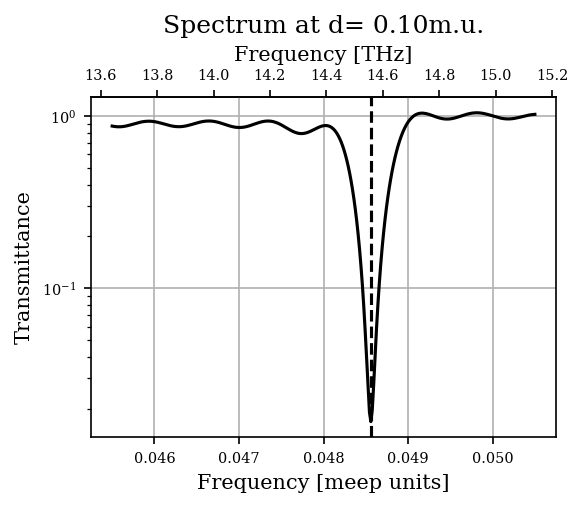

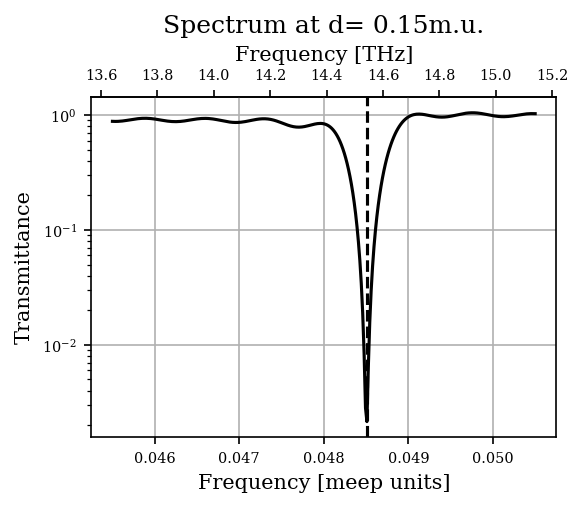

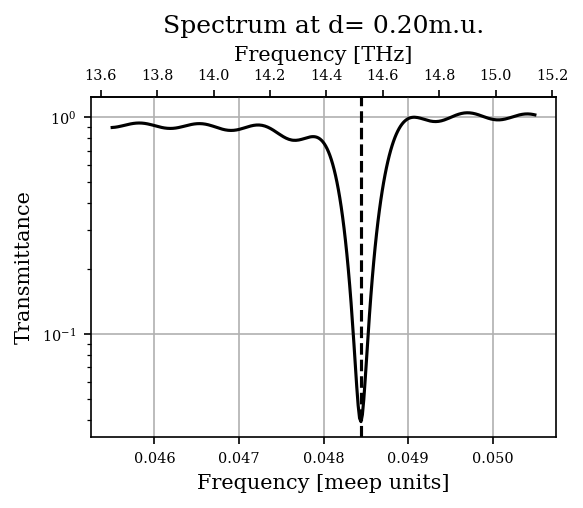

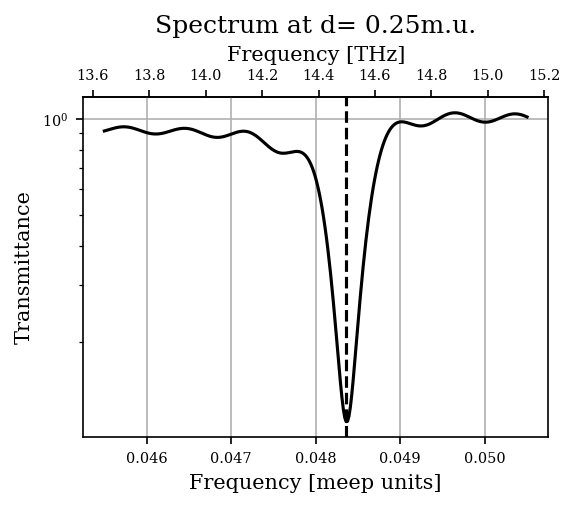

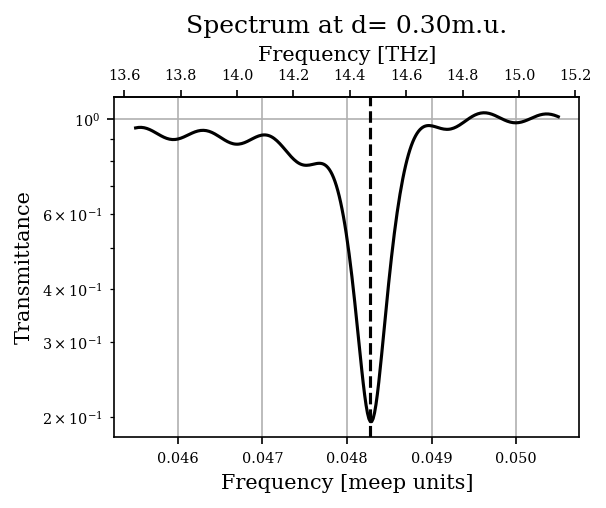

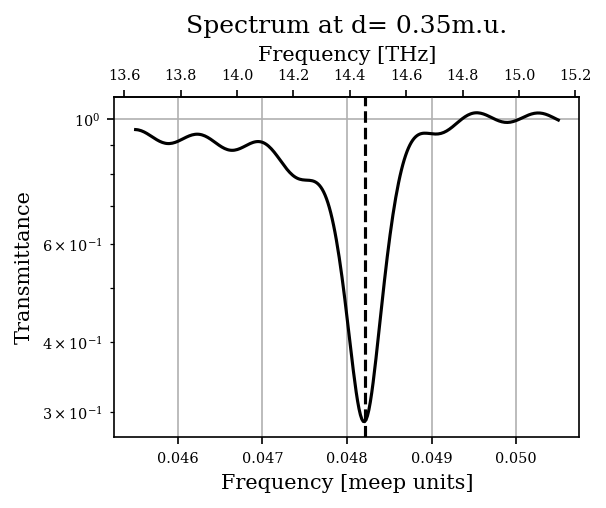

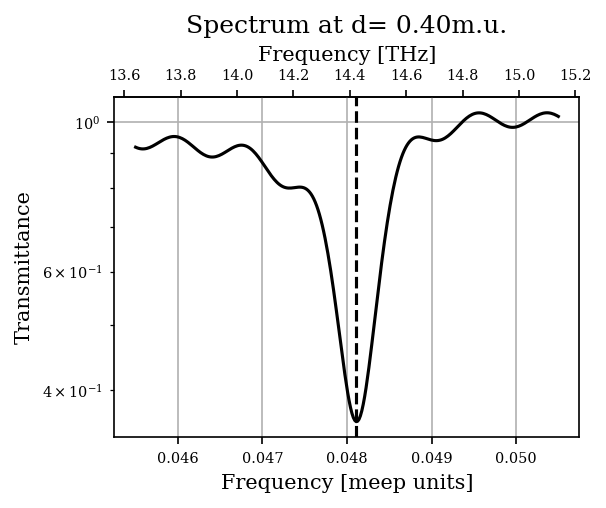

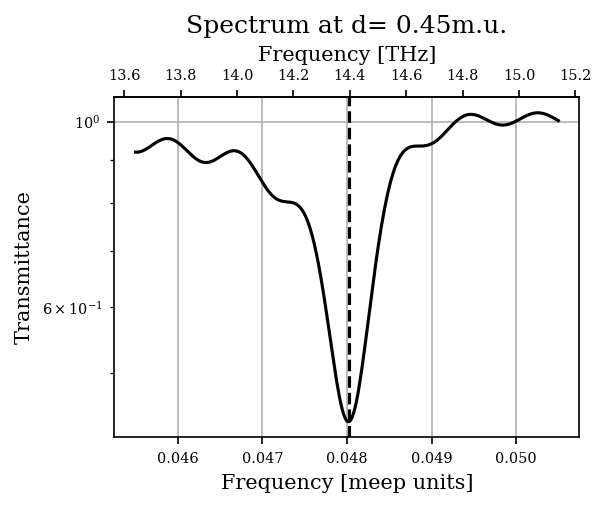

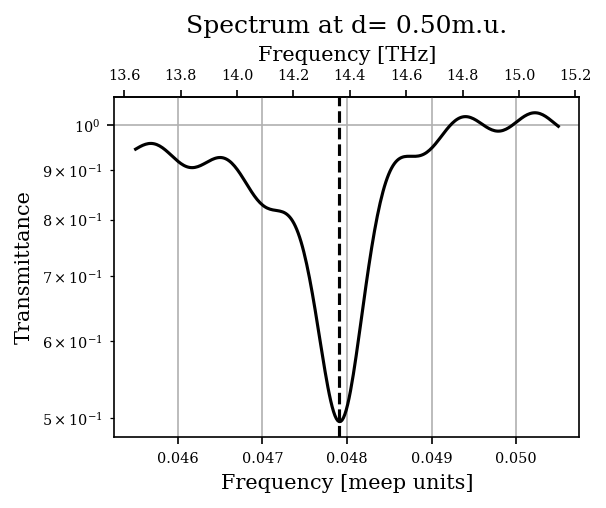

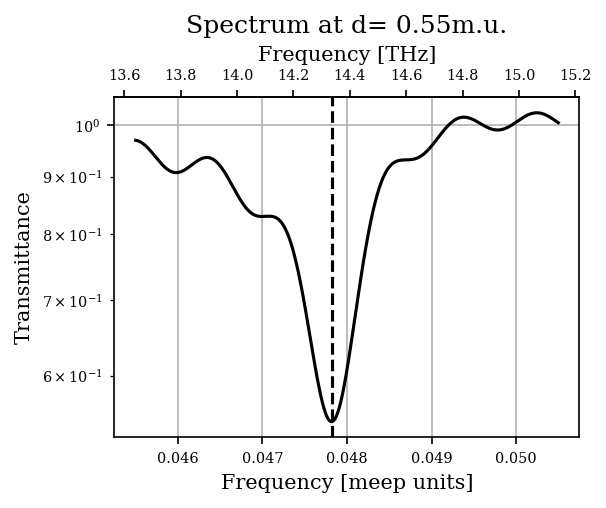

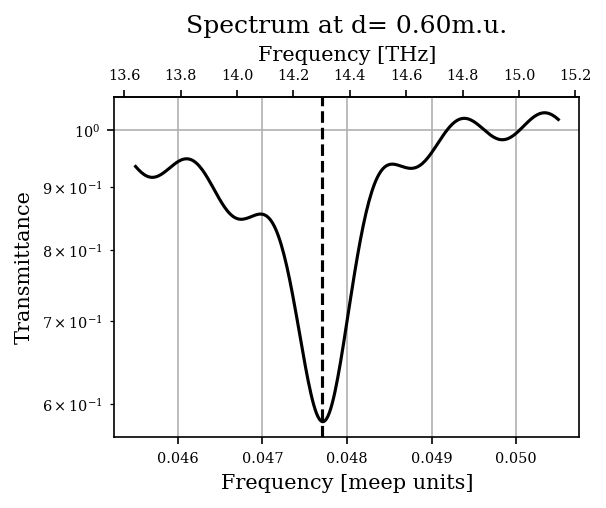

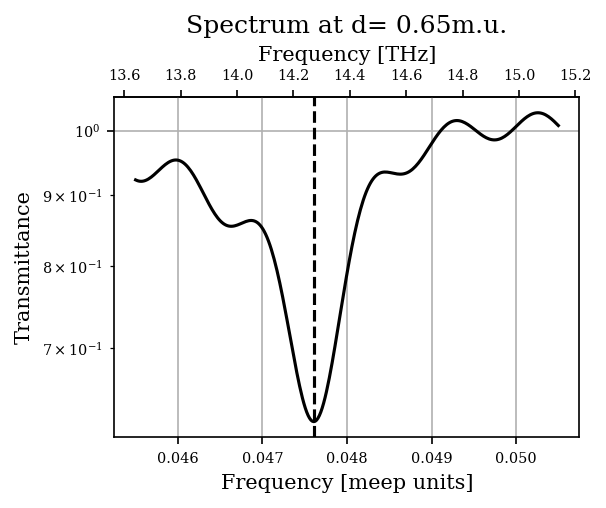

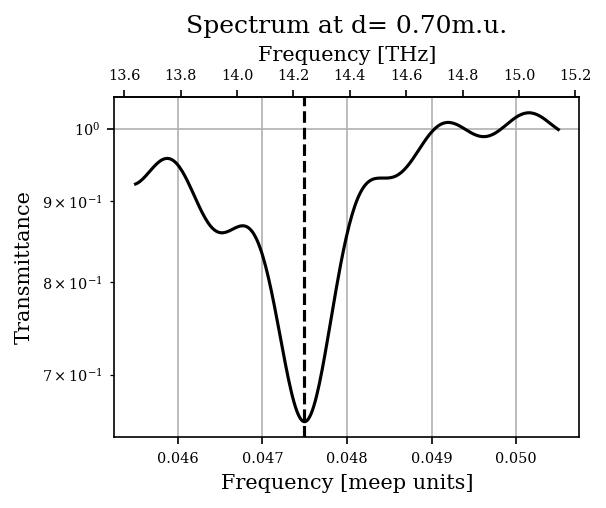

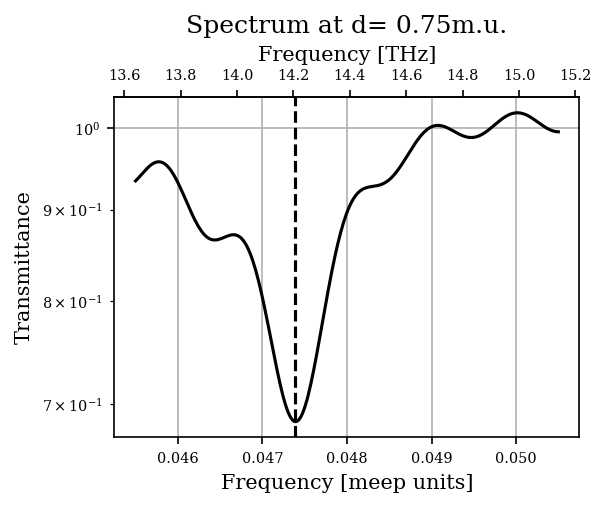

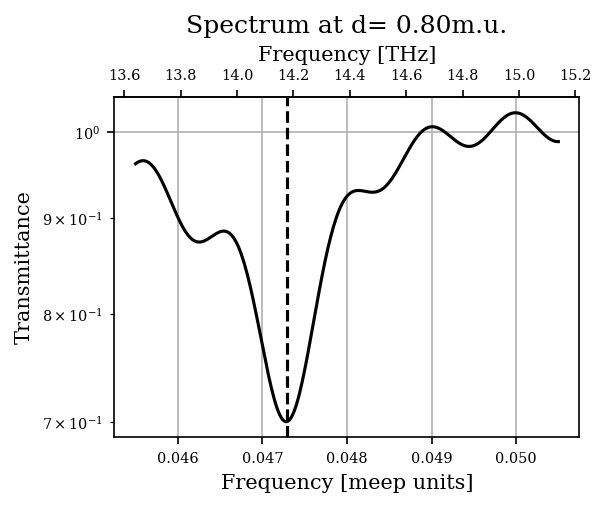

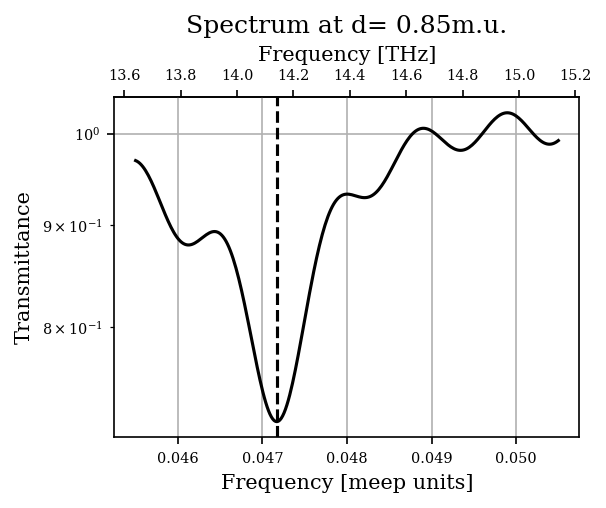

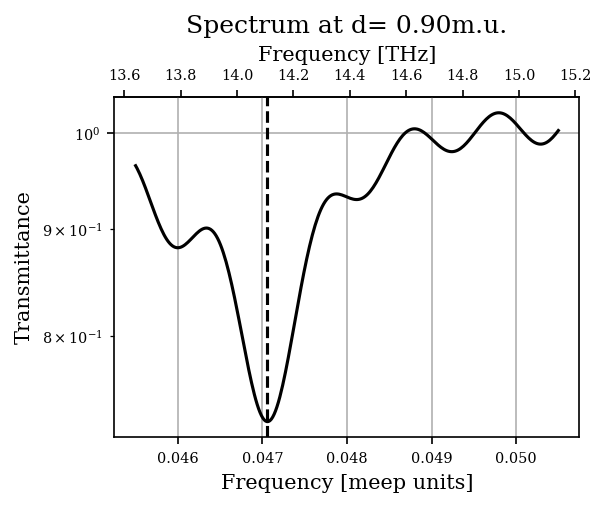

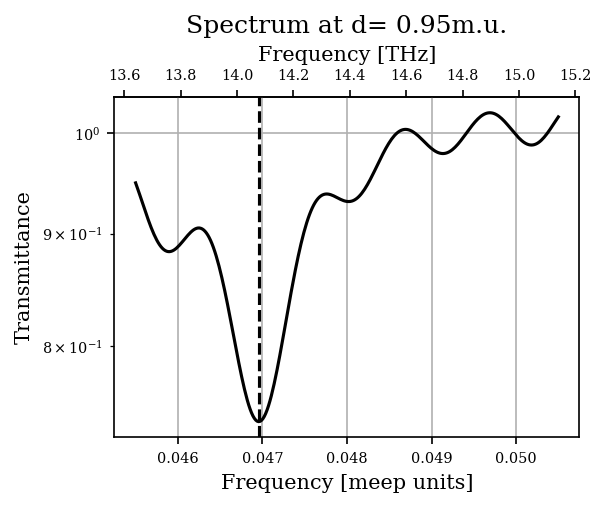

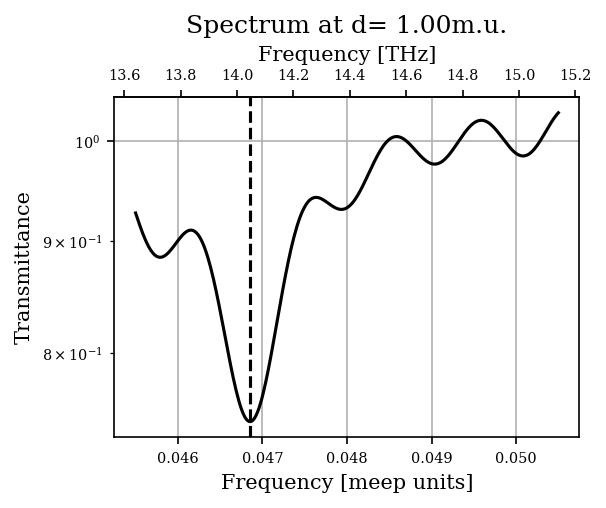

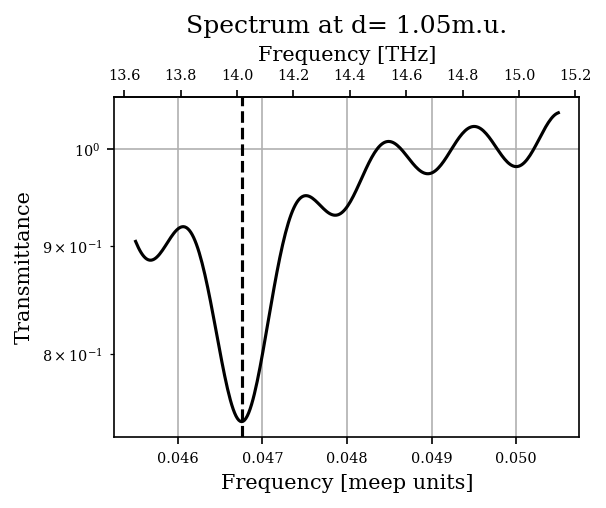

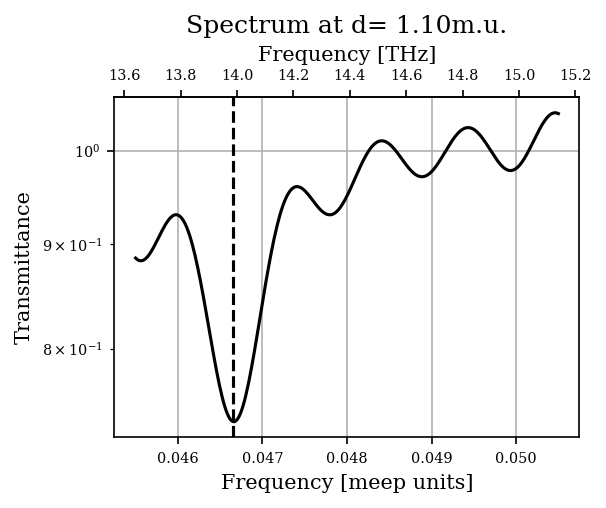

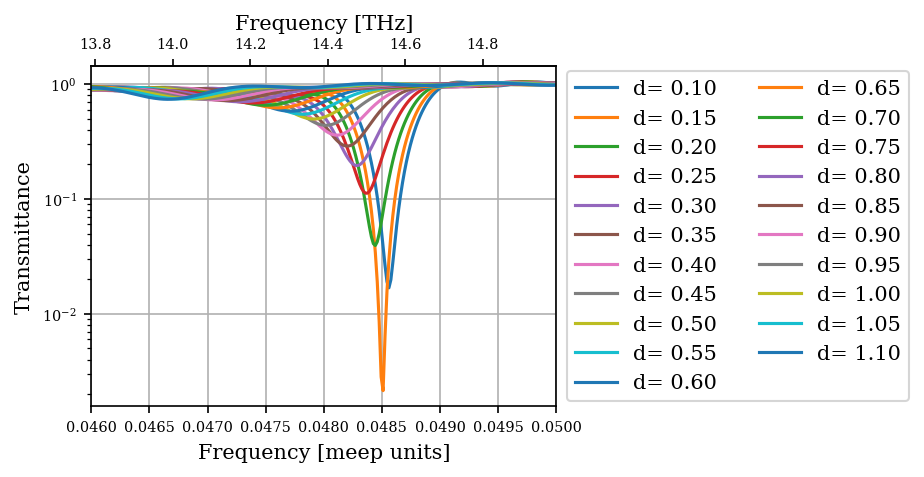

In [8]:
print("Beginning Resonance search")

multifig = plt.figure(1)

plt.xlabel("Frequency [meep units]")
plt.ylabel("Transmittance")
plt.yscale('log', nonpositive='clip')

axtot = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = axtot.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')




for index,d in enumerate(distances):
    #Geometry objects
    print("###############")
    print("Beginning iteration: ",index)
    print("Distance: ",d)

    #Position properties
    wvg_x = 0
    wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

    ring_x = 0
    ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

    #Soure parameters
    source_x = x_bound_low + 1
    source_y = wvg_y

    source_width = wvg_width

    #prediction of fundamental resonance
    fund_resonance = 1/(2*pi*(ring_r+ring_w/2)*n_ring)

    #Resonance values
    m = 8
    f_central_guess = 0.048
    df_guess = 0.005


    #Monitor parameters
    
    #central frequency
    f_mon = f_central_guess
    #width of sampled frequency band
    df_mon = df_guess

    #input
    mon_1_x = source_x + 2
    mon_1_y = wvg_y
    mon_1_width = wvg_width + 4

    #output
    mon_2_x = x_bound_up - 4
    mon_2_y = wvg_y
    mon_2_width = wvg_width + 4

    #number of sampling points in frequency for fourier transform of fields accumulated
    N_freq = 300

    check_pt = mp.Vector3(mon_2_x - 0.1, mon_2_y)
    
    waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
    ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
    int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

    geometry = [waveguide,
            ext_ring,
            int_ring]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.GaussianSource(frequency=f_central_guess, fwidth=df_guess*3),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)

    # Flux Monitor 1
    incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
    incident = sim.add_flux(f_mon, df_mon, N_freq, incident_fr)

    # Flux Monitor 2
    tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
    tran = sim.add_flux(f_mon, df_mon, N_freq, tran_fr)

    #Simulate
    mp.verbosity(0)
    sim.run( until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 1e-3))

    #Get fluxes from fourier transformed fields transmitted
    norm_tran_flux = mp.get_fluxes(tran)

    #Get fluxes from fourier transformed incident fields
    norm_inc_flux = mp.get_fluxes(incident)

    flux_freqs = mp.get_flux_freqs(tran)

    Tr = np.array(norm_tran_flux)/np.array(norm_inc_flux)
    freq_res_main = flux_freqs[np.argmin(Tr)]

    loop_f_central_resonance = np.append(loop_f_central_resonance, freq_res_main)
    print("Resonance frequency: ", freq_res_main )

    loop_attenuation = np.append(loop_attenuation, Tr[np.argmin(Tr)])
    print("Resonance attenuation: ", Tr[np.argmin(Tr)])

    plt.figure()
    plt.plot(flux_freqs, Tr, color='k')

    plt.xlabel("Frequency [meep units]")
    plt.ylabel("Transmittance")
    plt.yscale('log', nonpositive='clip')
    
    ax = plt.gca()

    def MU2THz(x):
        return x *freq_unit*1e-12


    def THz2MU(x):
        return x /(freq_unit*1e-12)

    secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
    secax.set_xlabel('Frequency [THz]')
    

    plt.axvline(freq_res_main , color='k', linestyle='--')

    plt.title('Spectrum at d= '+"{:.2f}".format(d)+"m.u.")

    plt.grid()

    plt.savefig('img/final/spectrum' +str(index)+ '.png')

    plt.figure(1)
    plt.plot(flux_freqs, Tr, label='d= '+"{:.2f}".format(d))
    
    

    sim.reset_meep()
print(loop_f_central_resonance)

plt.figure(1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()
plt.xlim([0.046,0.05])
plt.savefig('img/final/spectrum_tot.png')

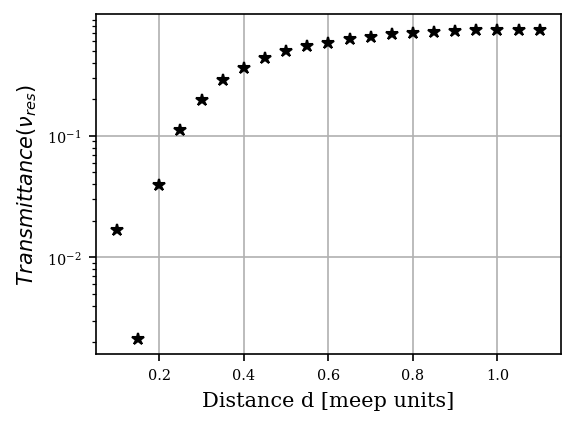

In [9]:
plt.plot(distances, loop_attenuation, "k*")

plt.xlabel(r"Distance d [meep units]")
plt.ylabel(r"$Transmittance(\nu_{res})$")

plt.yscale('log', nonpositive='clip')

plt.grid()
plt.show()

# $\Delta \phi$ calculation

In [10]:
run_time = 550

Delta_Phi_list = []

###############
Beginning iteration:  0
Distance:  0.1
Frequency:  0.048560200668896325


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 3)
K_init:  0.7083636197168378  phi_init: 5.502214415498919
K_fin:  0.7083636197690478  phi_fin: 0.7278436185649184
Delta Phi: 1.5088145102455854 , Degrees:  86.44870350517036
###############
Beginning iteration:  1
Distance:  0.15000000000000002
Frequency:  0.04851003344481605


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.7083636197469021  phi_init: 5.643887140268252
K_fin:  0.7067700007898179  phi_fin: 0.7862816264577779
Delta Phi: 1.4255797933691126 , Degrees:  81.67970551918212
###############
Beginning iteration:  2
Distance:  0.20000000000000004
Frequency:  0.04844314381270903


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.705975877273768  phi_init: 5.841950385826689
K_fin:  0.7067700008050352  phi_fin: 0.88522942606087
Delta Phi: 1.3264643474137676 , Degrees:  76.00080878138385
###############
Beginning iteration:  3
Distance:  0.25000000000000006
Frequency:  0.04835953177257525


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.705975877249941  phi_init: 6.1243407359428055
K_fin:  0.7051835362411949  phi_fin: 1.0278050012230873
Delta Phi: 1.186649572459868 , Degrees:  67.990012262954
###############
Beginning iteration:  4
Distance:  0.30000000000000004
Frequency:  0.04827591973244147


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 3)
K_init:  0.7059758772144347  phi_init: 0.12354577864516614
K_fin:  0.7036041776450576  phi_fin: 1.226030282657283
Delta Phi: 1.102484504012117 , Degrees:  63.167709058468176
###############
Beginning iteration:  5
Distance:  0.3500000000000001
Frequency:  0.04820903010033445


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6981317007977217  phi_init: 0.17453292519895314
K_fin:  0.7051835361083167  phi_fin: 1.2393600664432602
Delta Phi: 1.064827141244307 , Degrees:  61.010101104279585
###############
Beginning iteration:  6
Distance:  0.40000000000000013
Frequency:  0.04810869565217391


/tmp/ipykernel_4236/4244319209.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6981317007977219  phi_init: 0.4537856055180498
K_fin:  0.70439297157205  phi_fin: 1.3594784382659517
Delta Phi: 0.9056928327479019 , Degrees:  51.89237685170273
###############
Beginning iteration:  7
Distance:  0.45000000000000007
Frequency:  0.04802508361204014


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6942746195712797  phi_init: 0.6103831028262867
K_fin:  0.710767568685244  phi_fin: 1.2438432451942472
Delta Phi: 0.6334601423679604 , Degrees:  36.294592647440396
###############
Beginning iteration:  8
Distance:  0.5000000000000001
Frequency:  0.047908026755852845


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 3)
K_init:  0.6904599239683694  phi_init: 0.8573210749708693
K_fin:  0.7180783208428072  phi_fin: 1.1471301169084933
Delta Phi: 0.289809041937624 , Degrees:  16.604834967755732
###############
Beginning iteration:  9
Distance:  0.5500000000000002
Frequency:  0.04782441471571906


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6904599238658787  phi_init: 1.0874743800883024
K_fin:  0.7383296493751431  phi_fin: 0.48545170955471484
Delta Phi: -0.6020226705335876 , Degrees:  -34.493358192769435
###############
Beginning iteration:  10
Distance:  0.6000000000000002
Frequency:  0.04770735785953177


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6851892374309748  phi_init: 1.296720633079147
K_fin:  0.7560993143037747  phi_fin: 6.273734086013568
Delta Phi: -1.3061718542451652 , Degrees:  -74.8381345670249
###############
Beginning iteration:  11
Distance:  0.6500000000000001
Frequency:  0.04760702341137124


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6851892374169758  phi_init: 1.5707963277597088
K_fin:  0.7597563844375742  phi_fin: 6.205310307237729
Delta Phi: -1.6486713277015657 , Degrees:  -94.46190888152961
###############
Beginning iteration:  12
Distance:  0.7000000000000002
Frequency:  0.04748996655518395


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 3)
K_init:  0.6829549246934237  phi_init: 1.9122737891411496
K_fin:  0.766242110428404  phi_fin: 6.137599311352773
Delta Phi: -2.057859784967963 , Degrees:  -117.90668050836341
###############
Beginning iteration:  13
Distance:  0.7500000000000002
Frequency:  0.04738963210702341


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6807351362147335  phi_init: 2.149421192863162
K_fin:  0.7671776928689983  phi_fin: 6.158518942101162
Delta Phi: -2.274087557941586 , Degrees:  -130.29561931326495
###############
Beginning iteration:  14
Distance:  0.8000000000000002
Frequency:  0.047289297658862875


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6807351362056423  phi_init: 2.4897887607089793
K_fin:  0.7662421101680393  phi_fin: 6.244873216018725
Delta Phi: -2.5281008518698407 , Degrees:  -144.84950899556998
###############
Beginning iteration:  15
Distance:  0.8500000000000002
Frequency:  0.04717224080267558


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6777977677508159  phi_init: 2.790832308402724
K_fin:  0.7653088067281398  phi_fin: 0.13966887190098465
Delta Phi: -2.651163436501739 , Degrees:  -151.90047571094928
###############
Beginning iteration:  16
Distance:  0.9000000000000002
Frequency:  0.04705518394648829


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 3)
K_init:  0.6756113233526342  phi_init: 3.1247023705055206
K_fin:  0.7643777741853696  phi_fin: 0.36307945737947644
Delta Phi: -2.761622913126044 , Degrees:  -158.22933752874593
###############
Beginning iteration:  17
Distance:  0.9500000000000003
Frequency:  0.04695484949832776


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6727179129793468  phi_init: 3.3534987962992666
K_fin:  0.762522488094289  phi_fin: 0.5032648624759251
Delta Phi: -2.8502339338233416 , Degrees:  -163.30637503304746
###############
Beginning iteration:  18
Distance:  1.0000000000000004
Frequency:  0.046854515050167224


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6727179129728441  phi_init: 3.622585961338192
K_fin:  0.7597563862842392  phi_fin: 0.7122715822896115
Delta Phi: -2.9103143790485806 , Degrees:  -166.74873097572058
###############
Beginning iteration:  19
Distance:  1.0500000000000003
Frequency:  0.04675418060200669


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 2)
K_init:  0.6705640669244174  phi_init: 3.8842423574117397
K_fin:  0.7570102783873336  phi_fin: 0.9803282981094048
Delta Phi: -2.903914059302335 , Degrees:  -166.38201966672645
###############
Beginning iteration:  20
Distance:  1.1000000000000005
Frequency:  0.04665384615384616


FloatProgress(value=0.0, description='0% done ', max=550.0)

(960, 3)
K_init:  0.6677136351724305  phi_init: 4.108108139850607
K_fin:  0.7533795316701292  phi_fin: 1.2995797445374349
Delta Phi: -2.8085283953131723 , Degrees:  -160.91682369409443


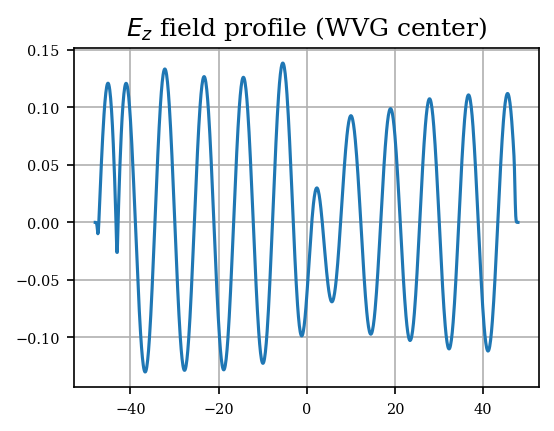

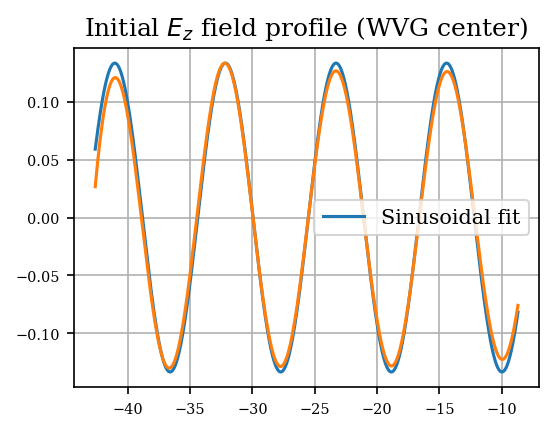

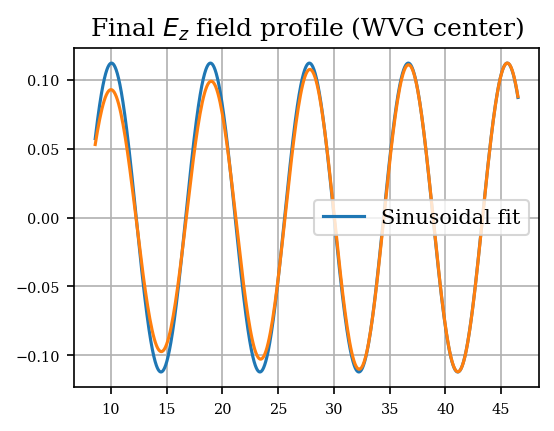

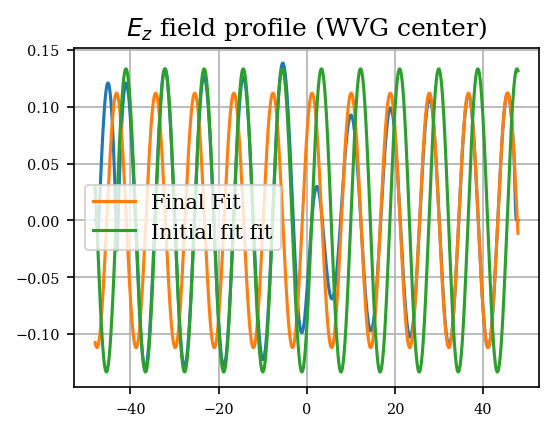

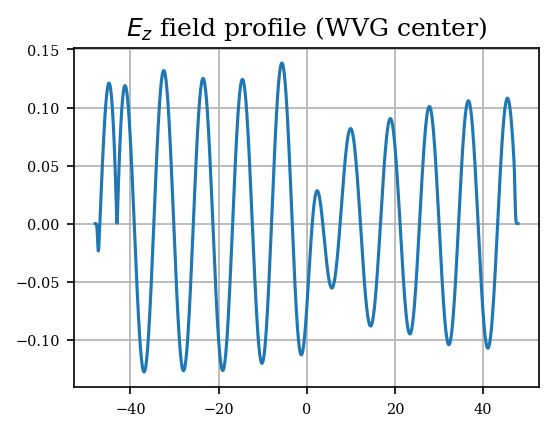

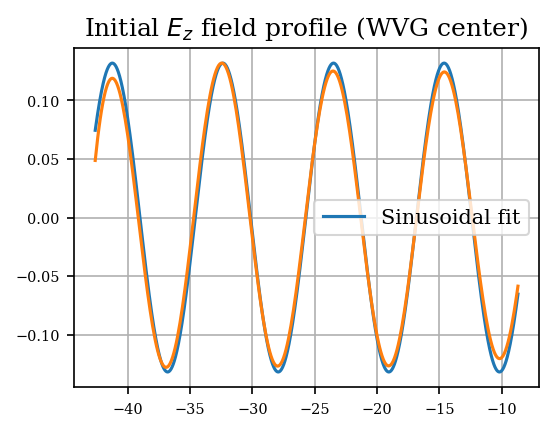

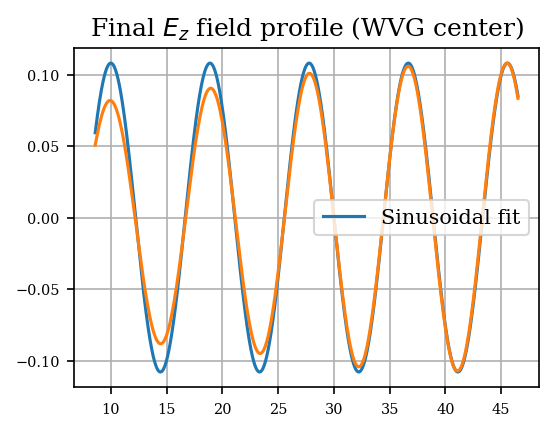

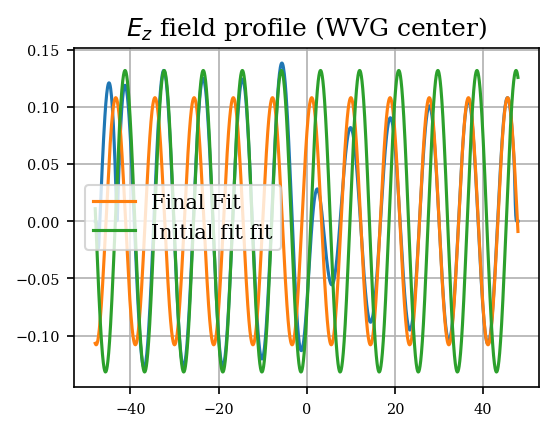

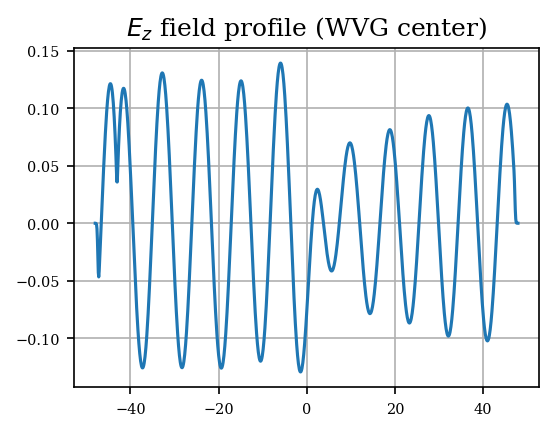

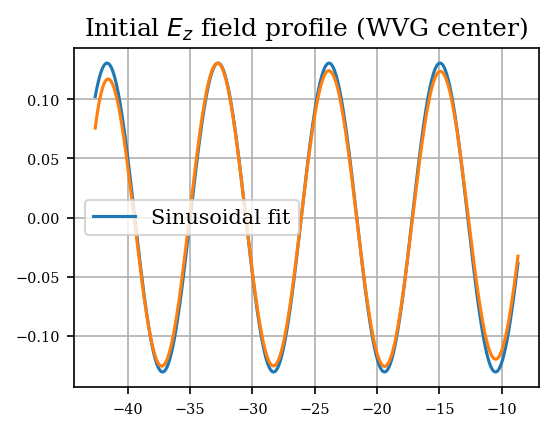

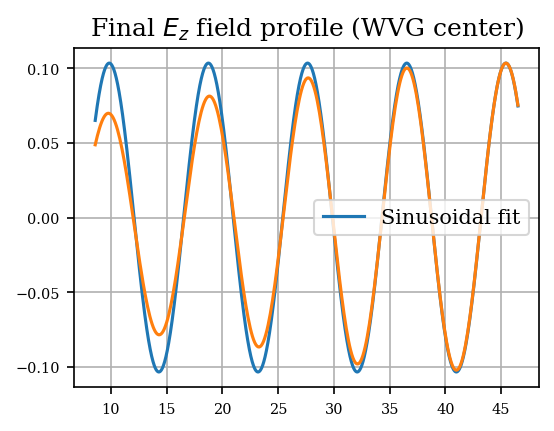

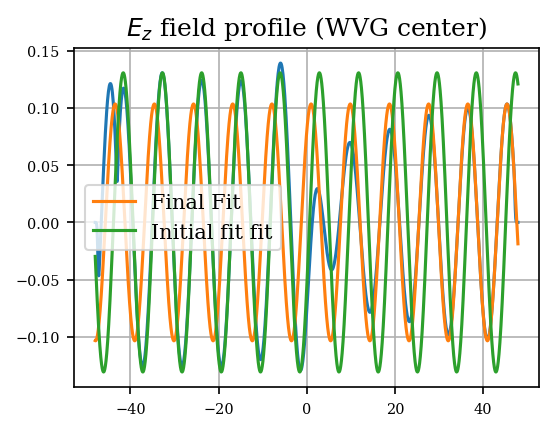

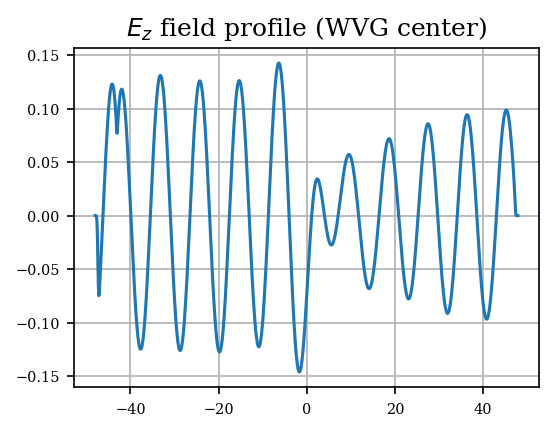

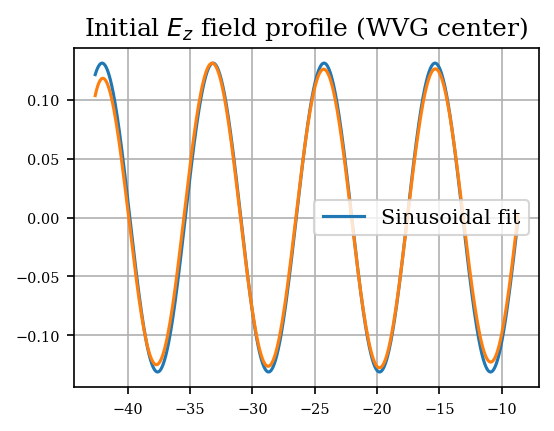

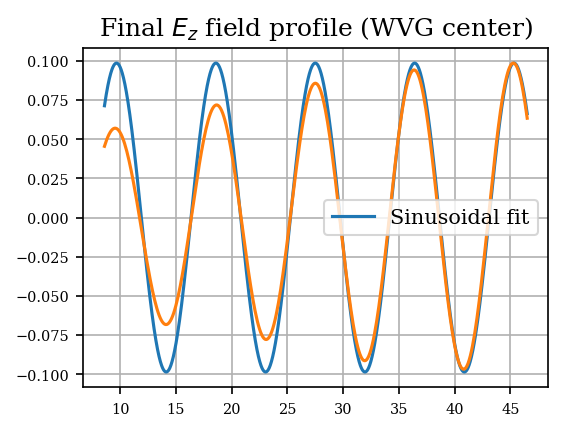

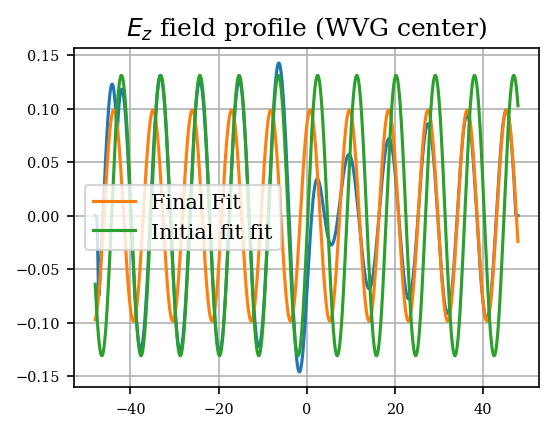

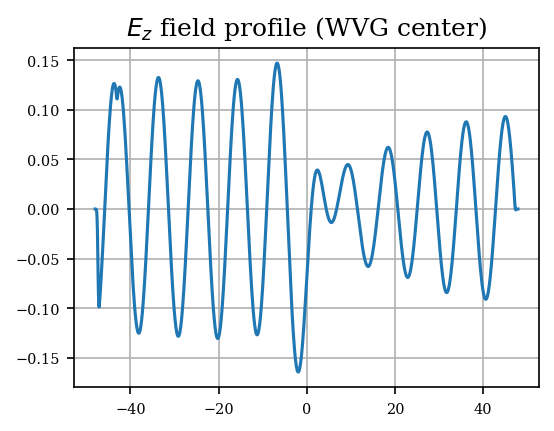

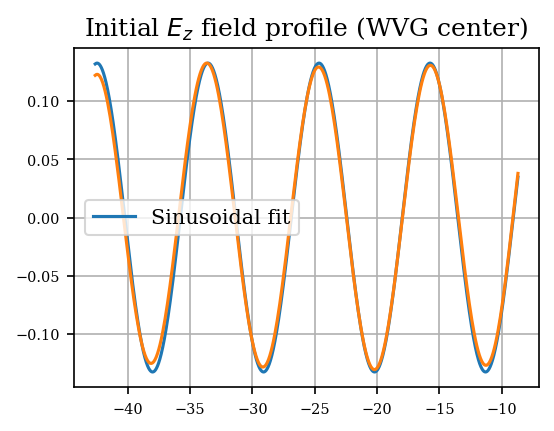

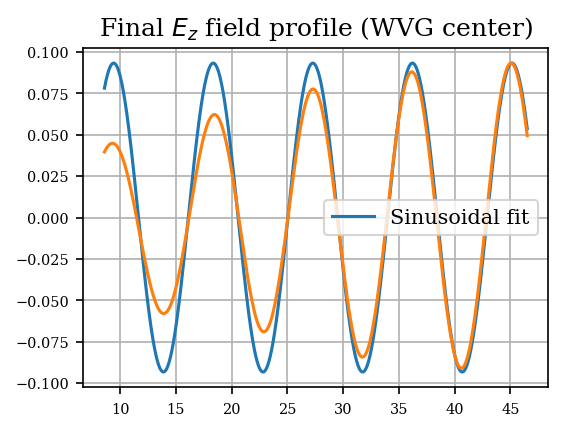

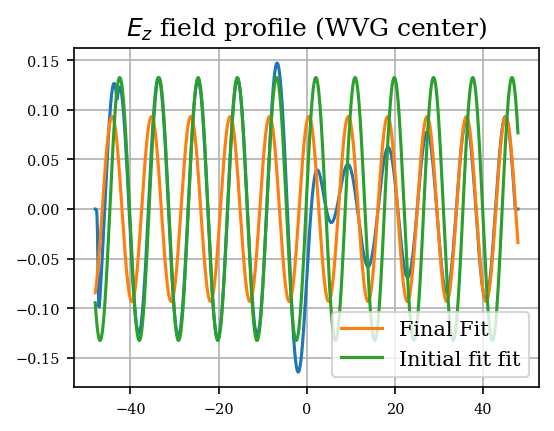

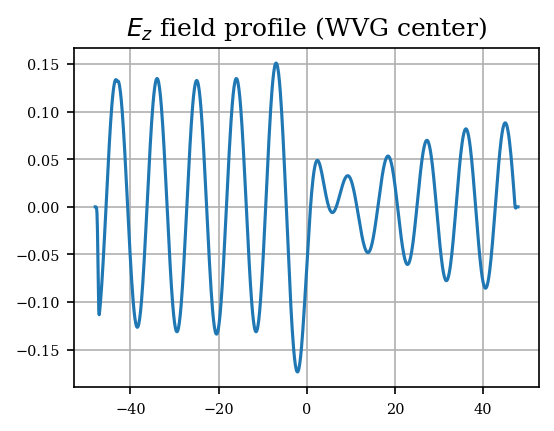

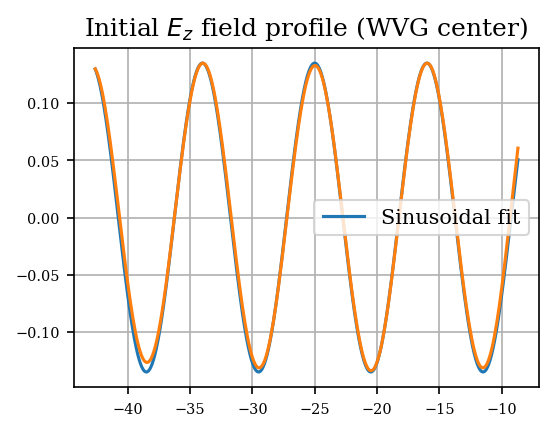

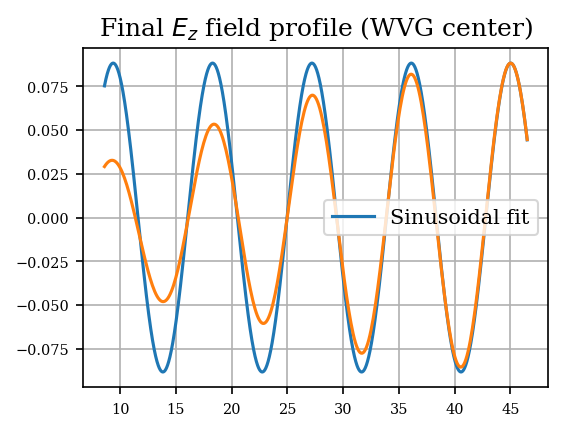

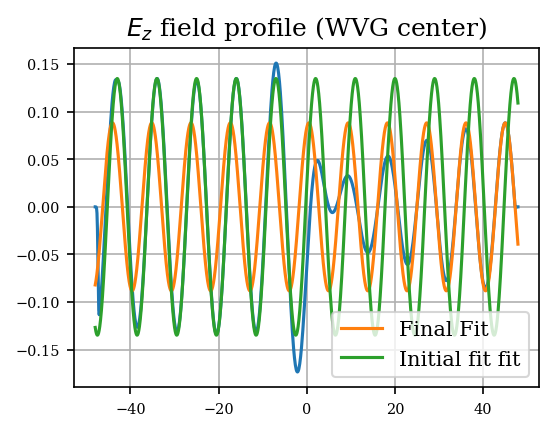

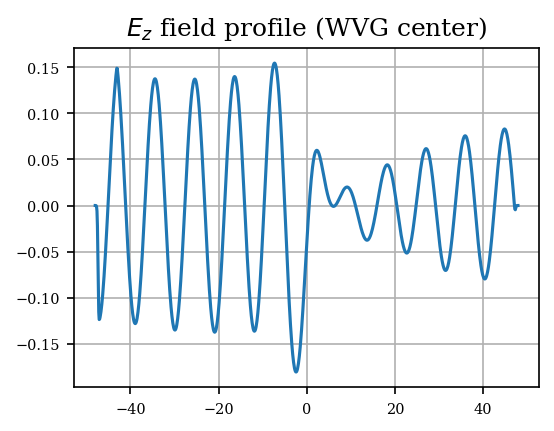

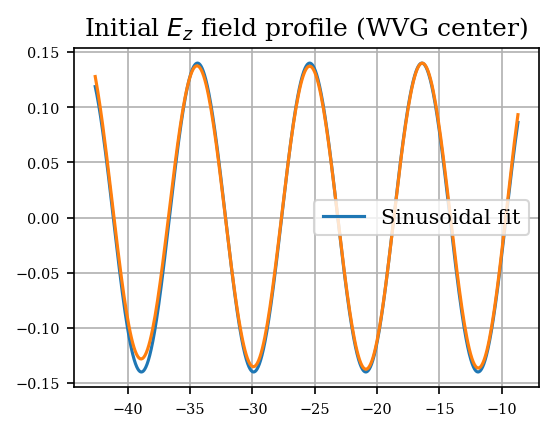

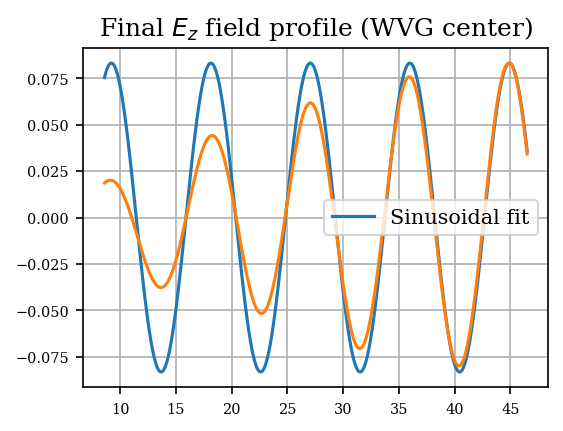

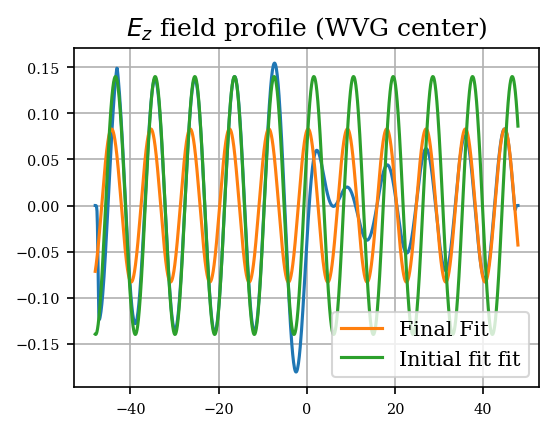

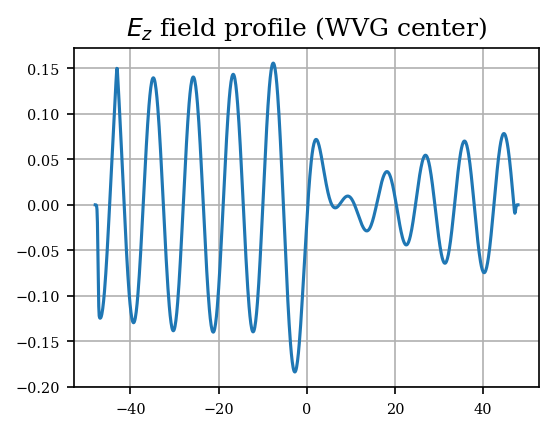

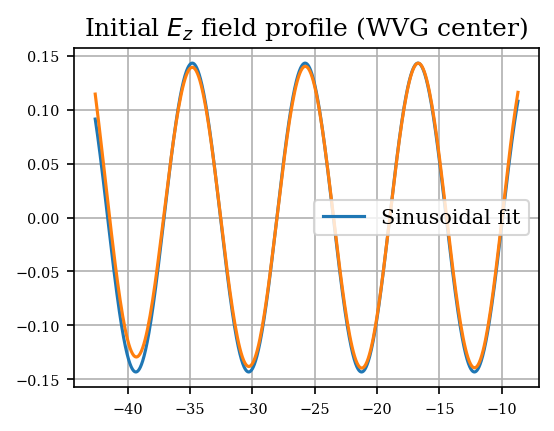

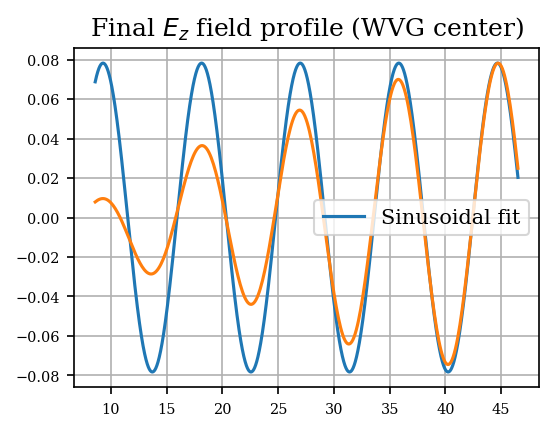

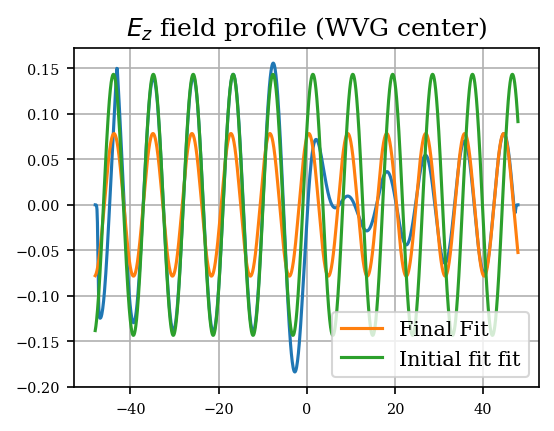

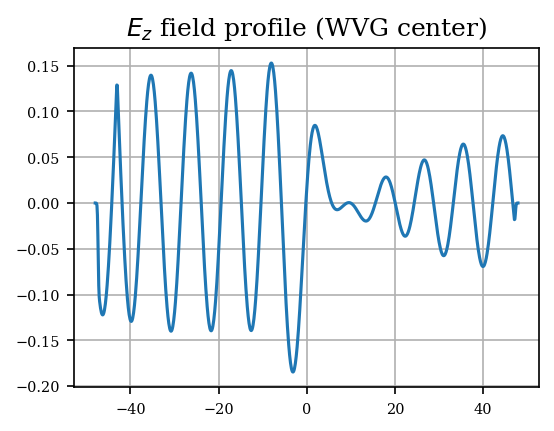

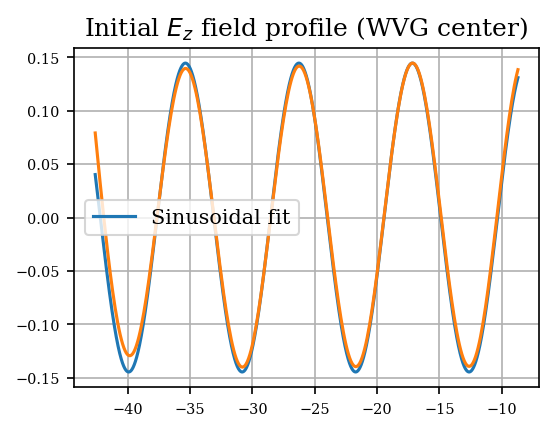

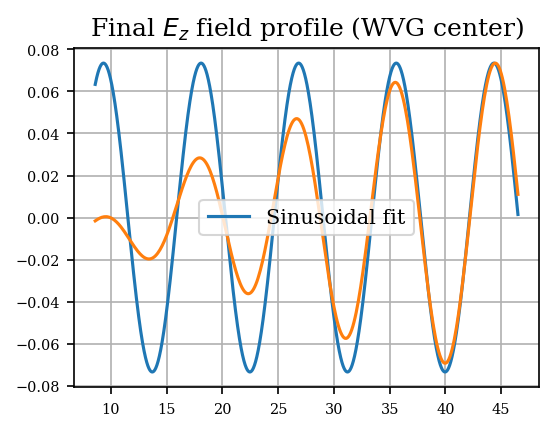

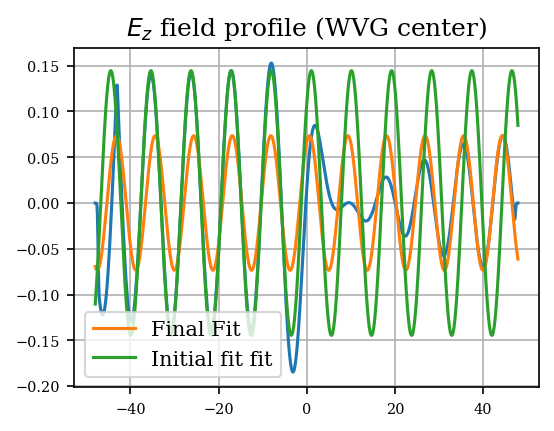

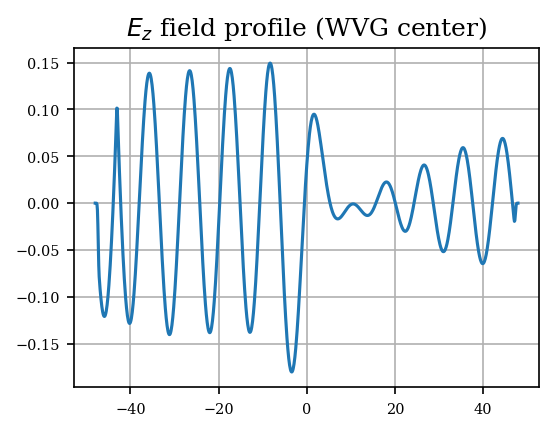

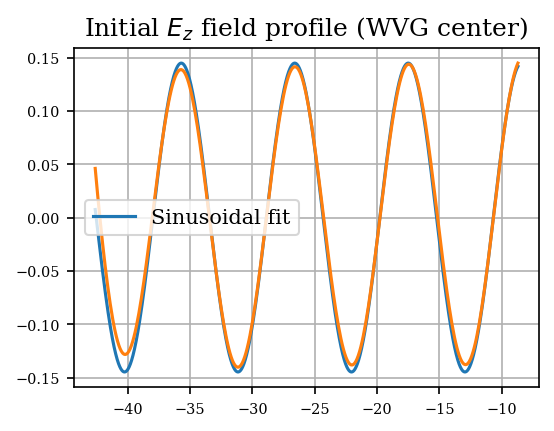

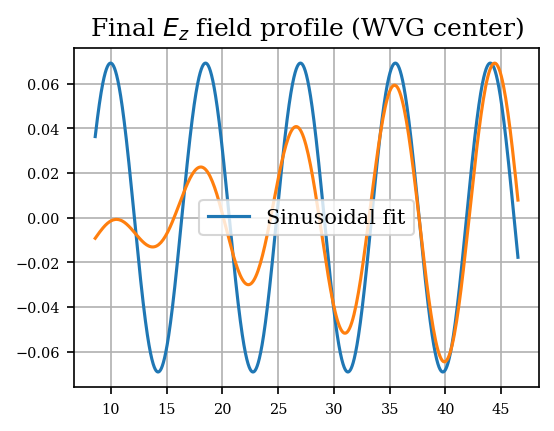

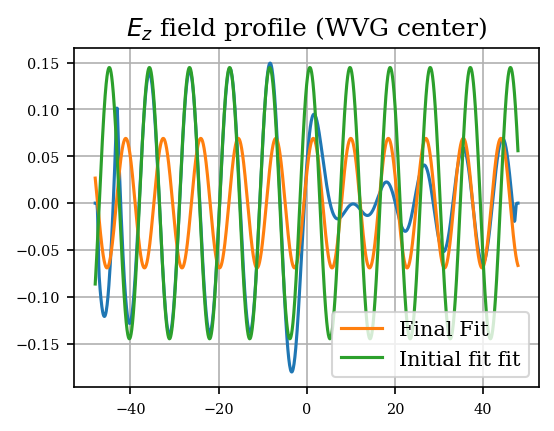

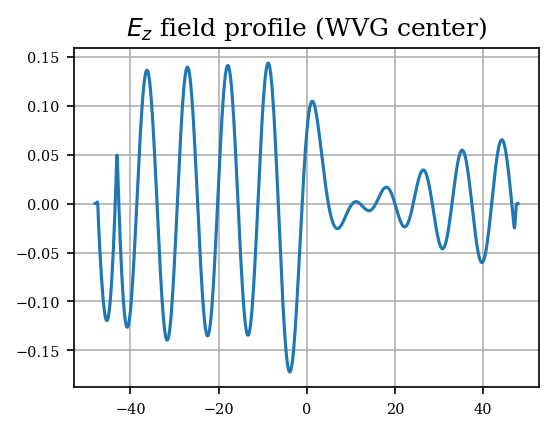

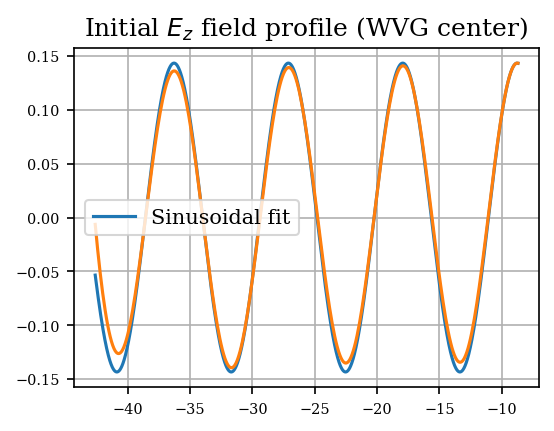

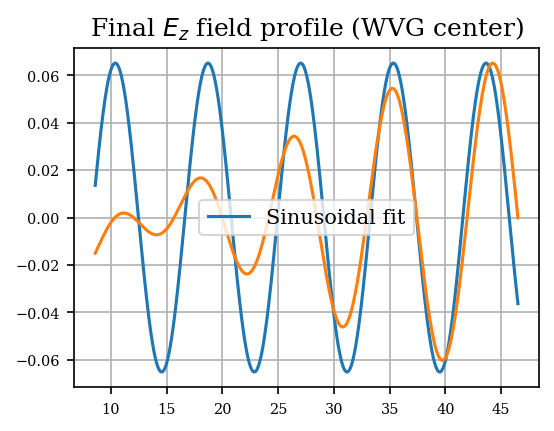

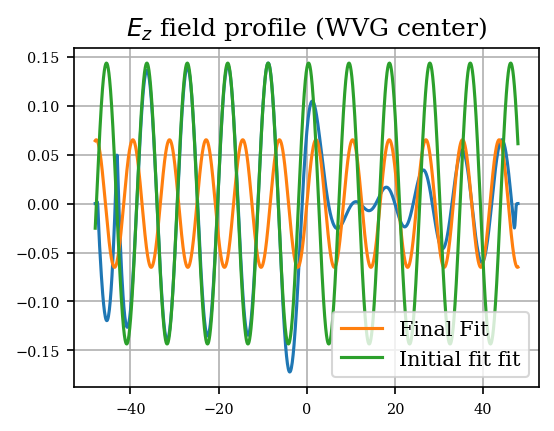

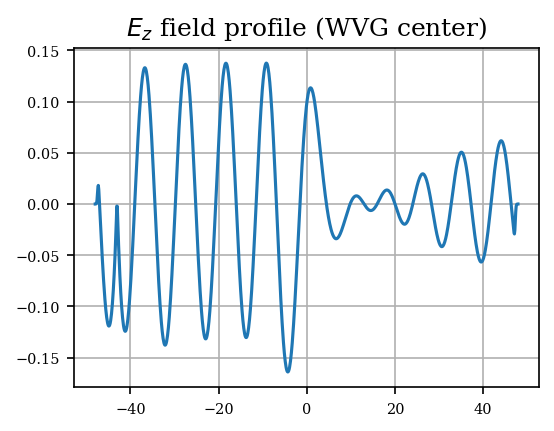

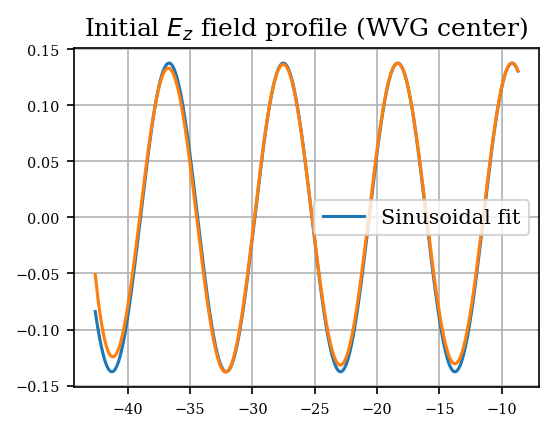

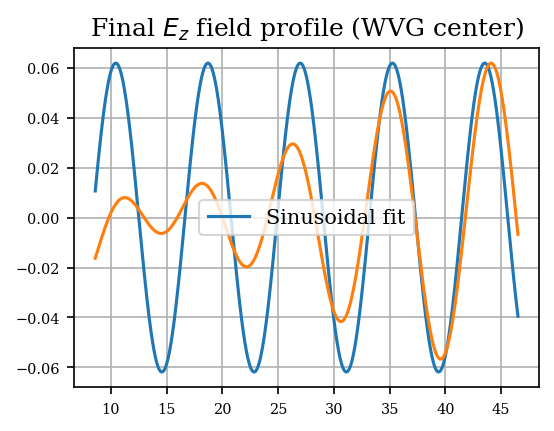

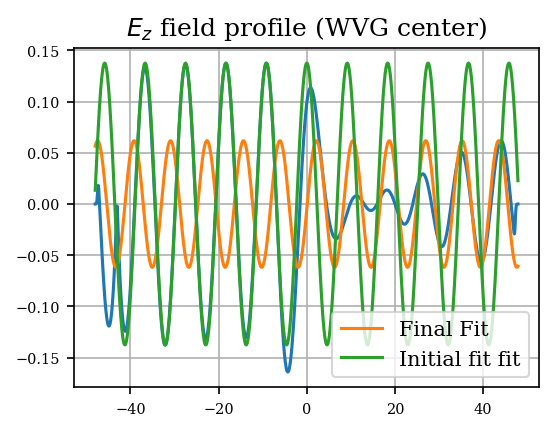

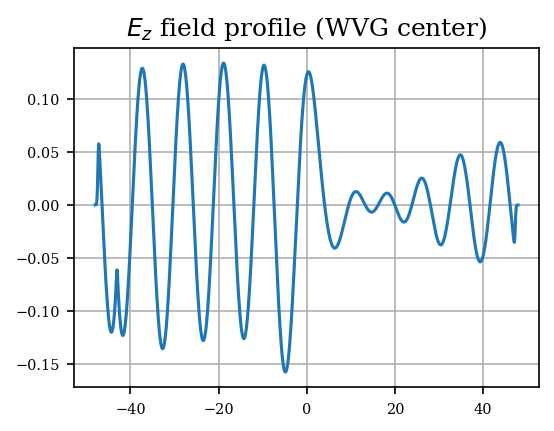

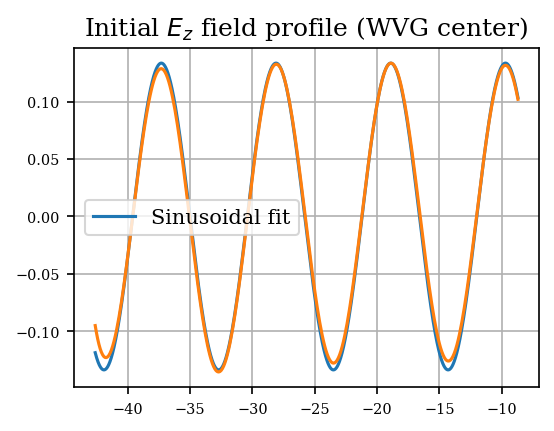

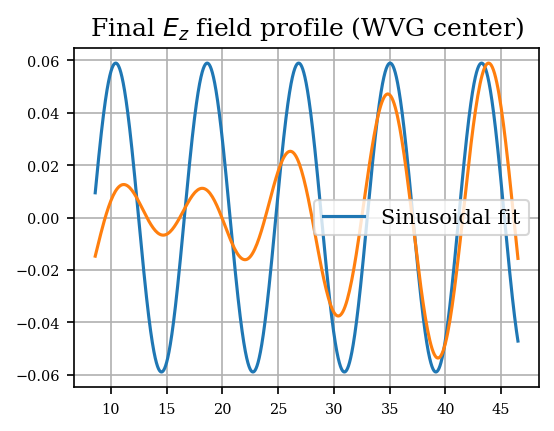

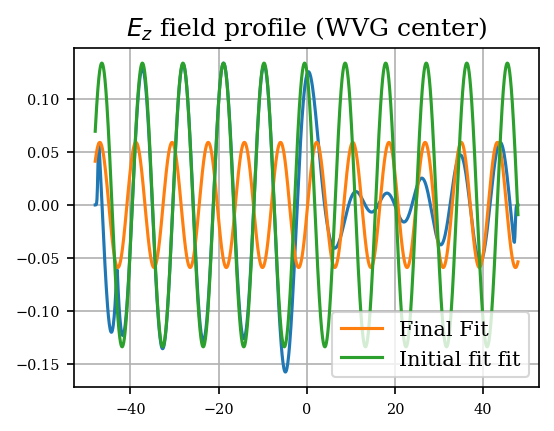

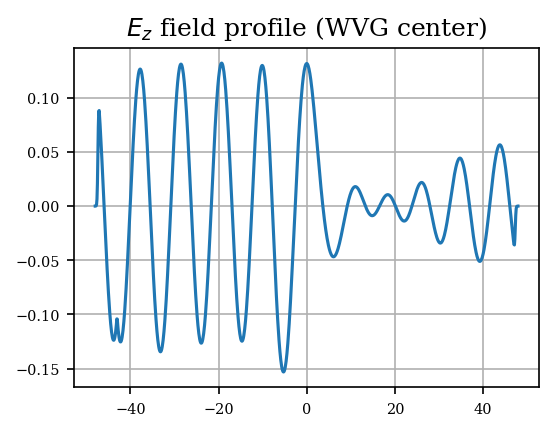

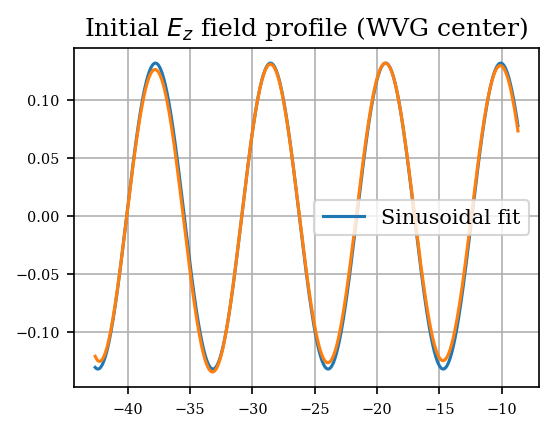

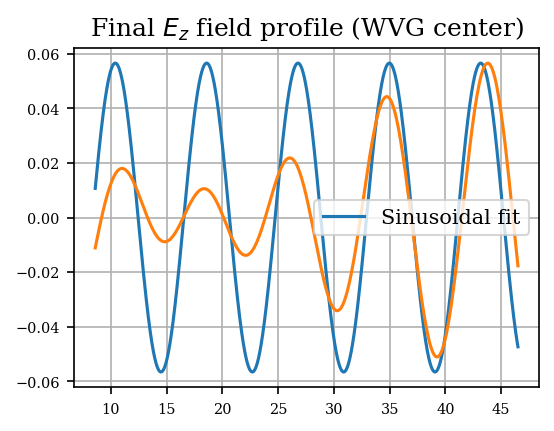

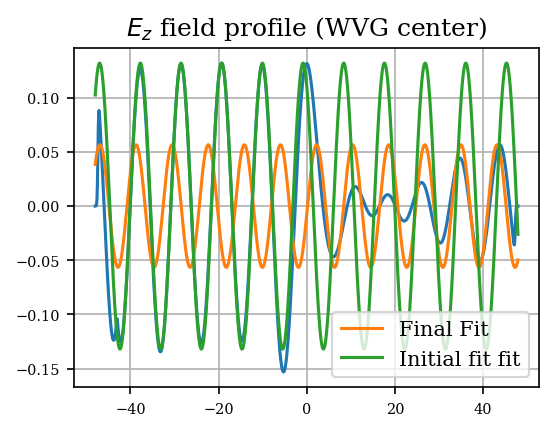

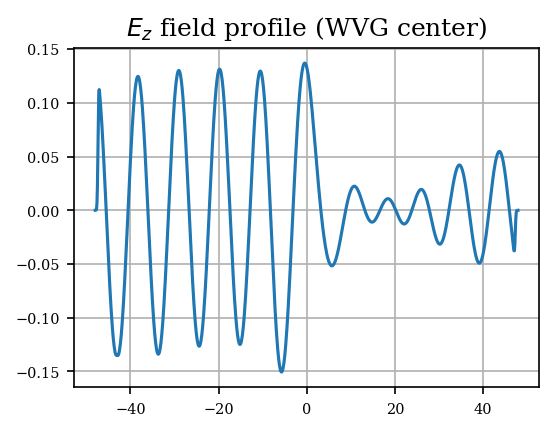

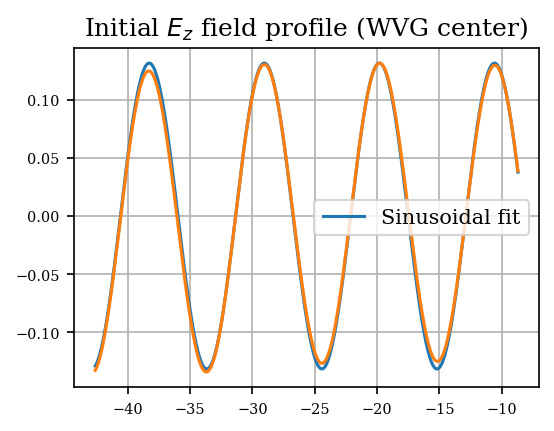

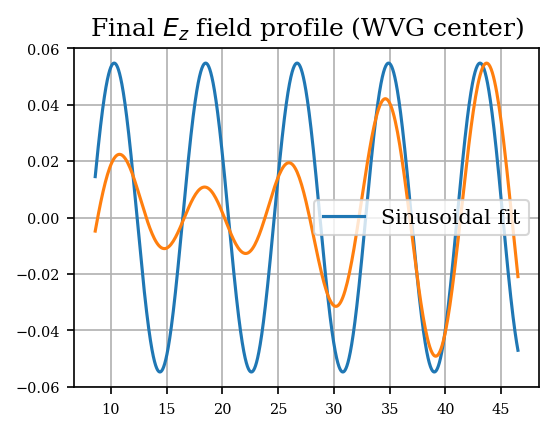

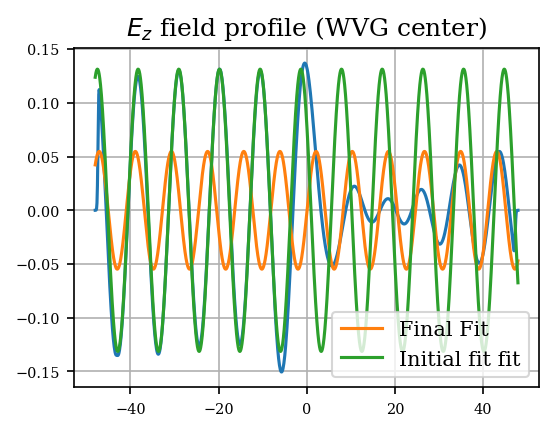

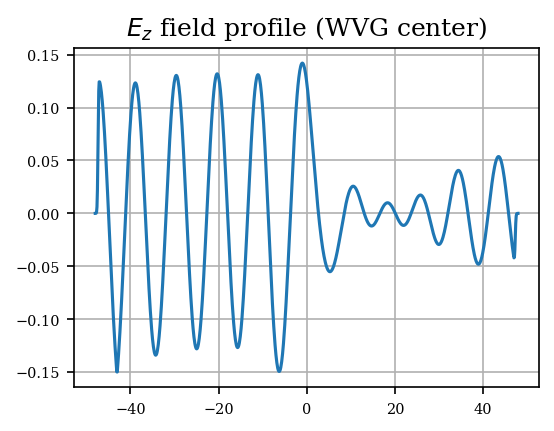

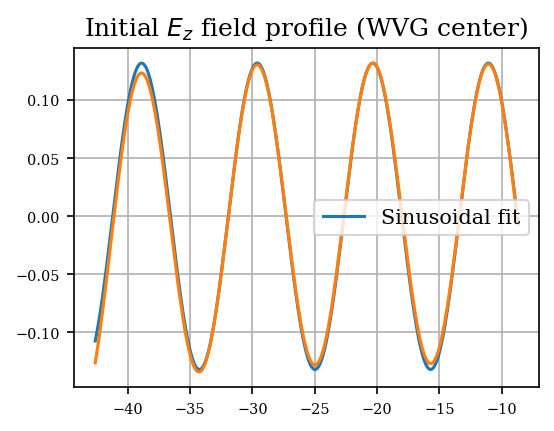

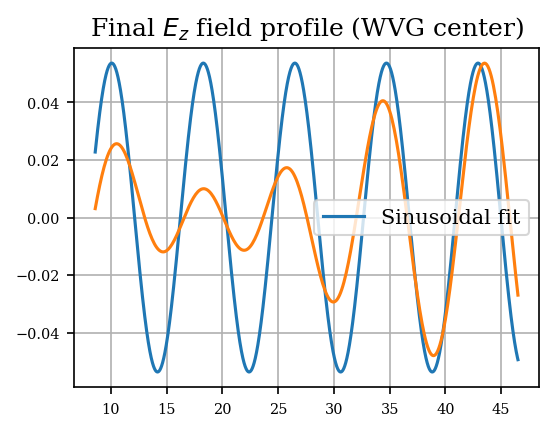

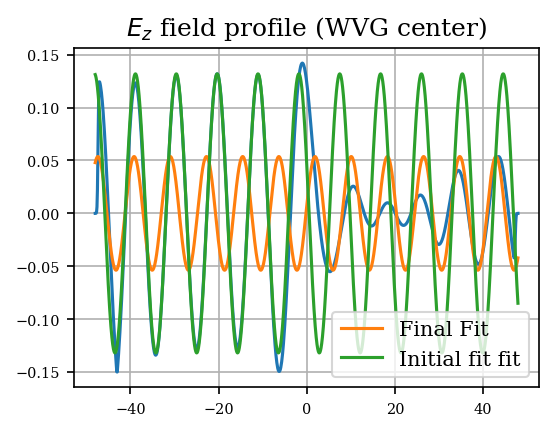

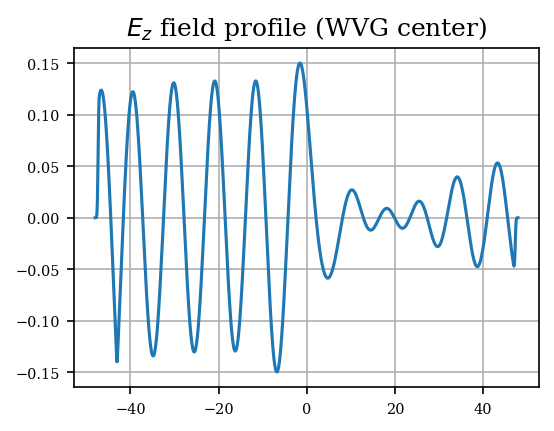

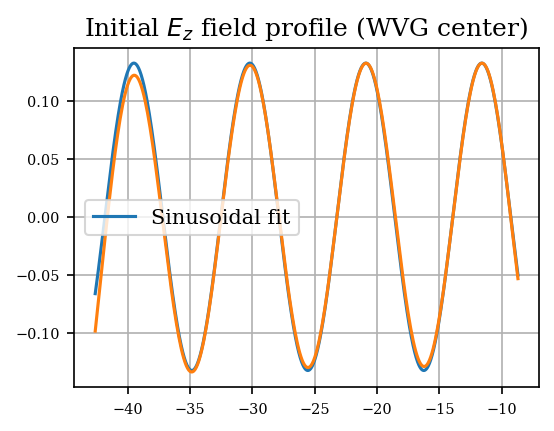

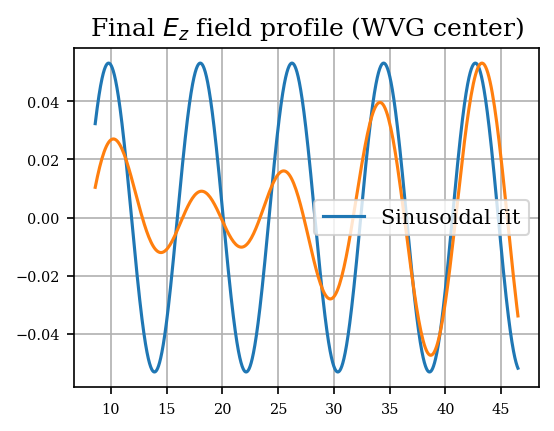

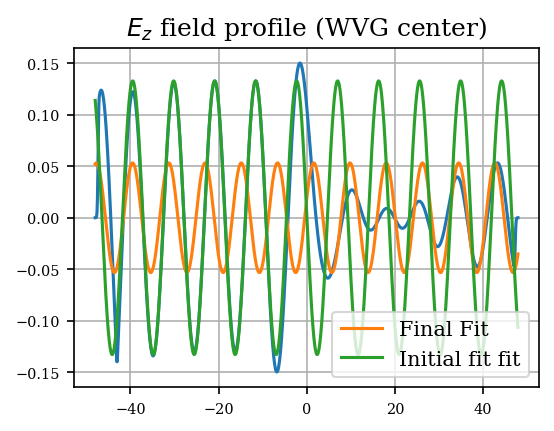

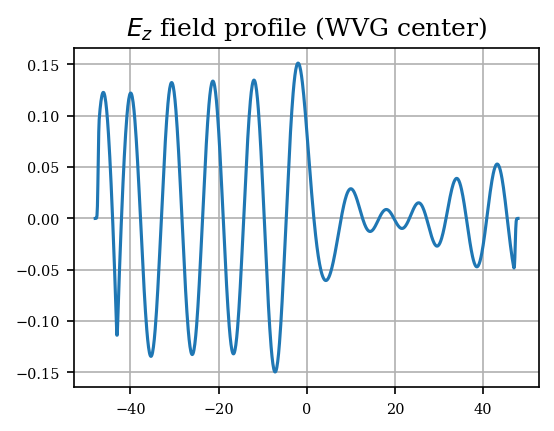

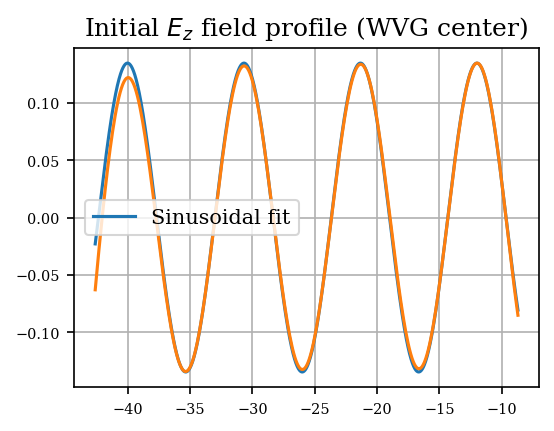

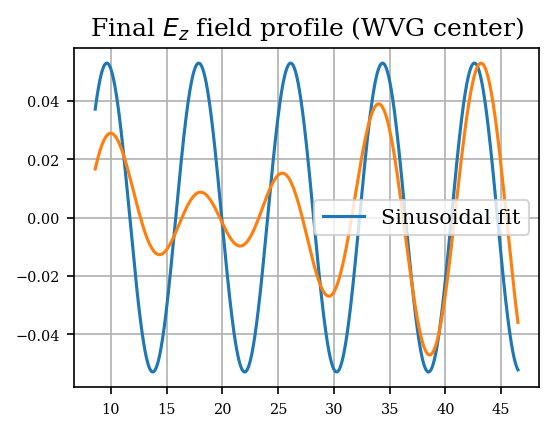

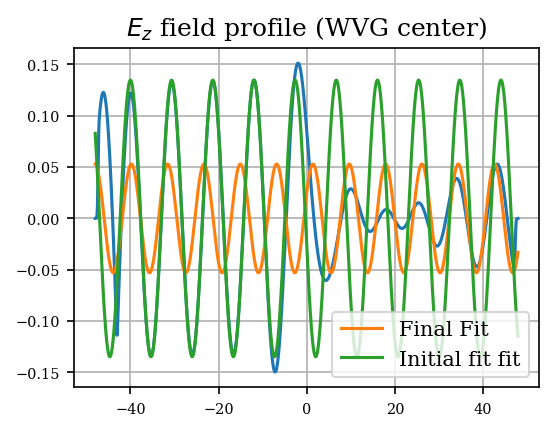

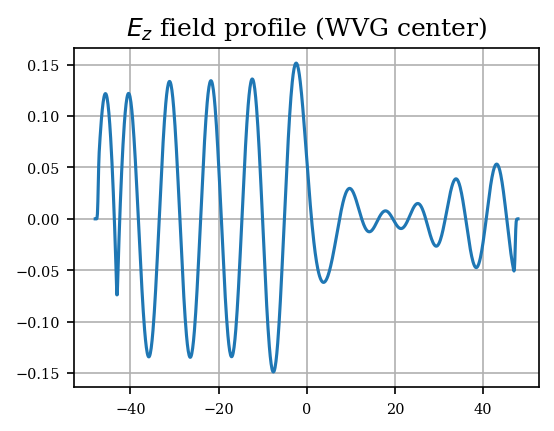

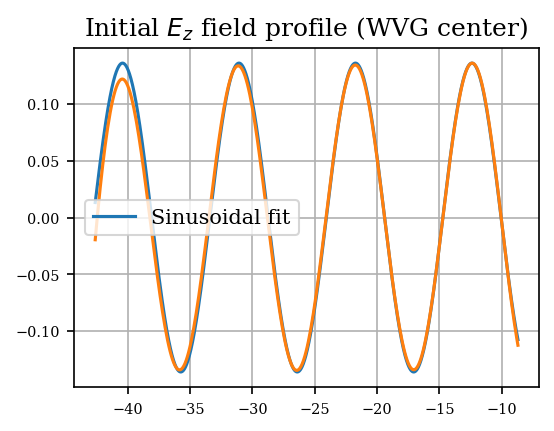

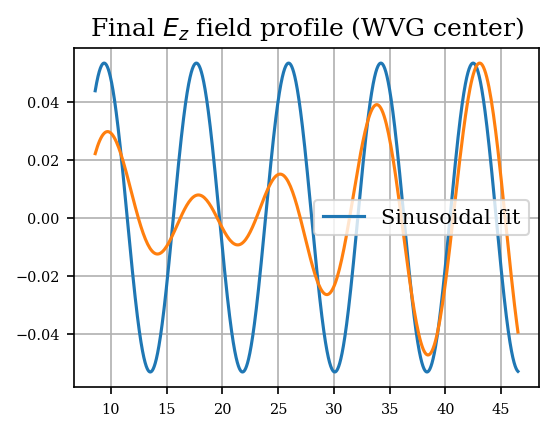

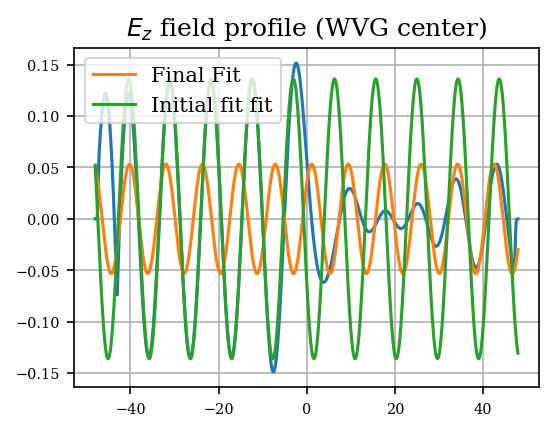

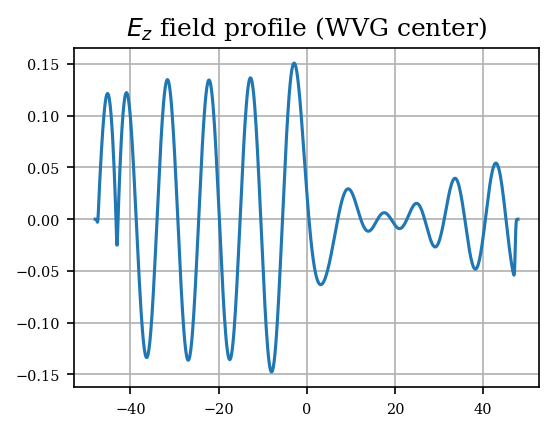

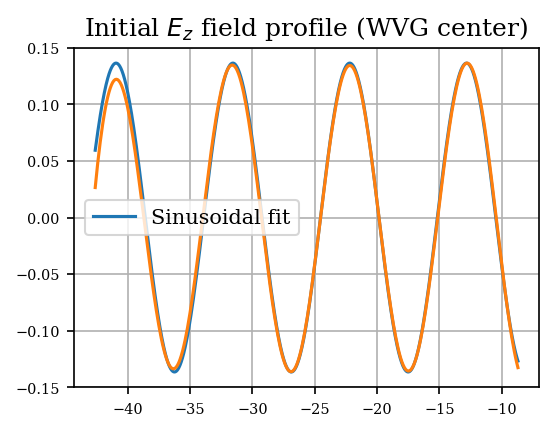

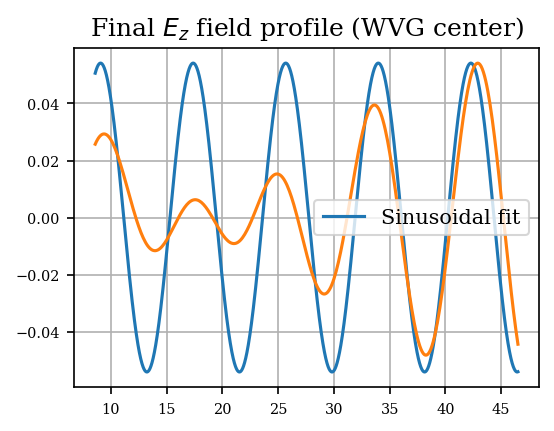

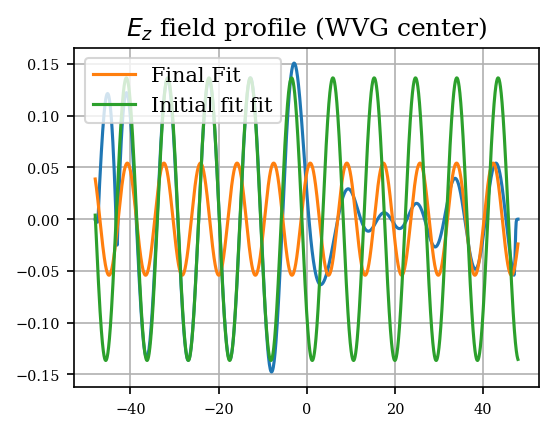

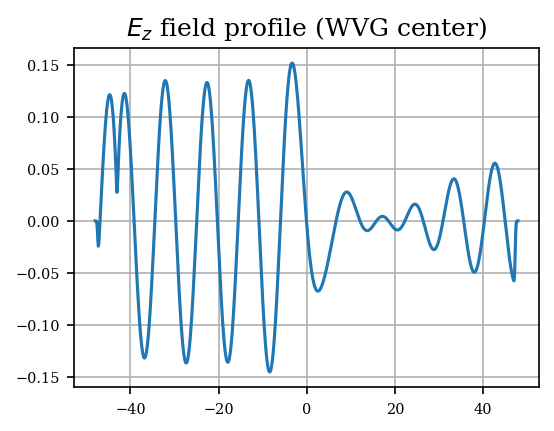

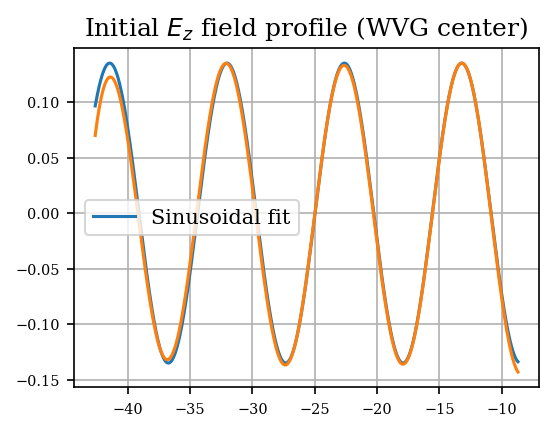

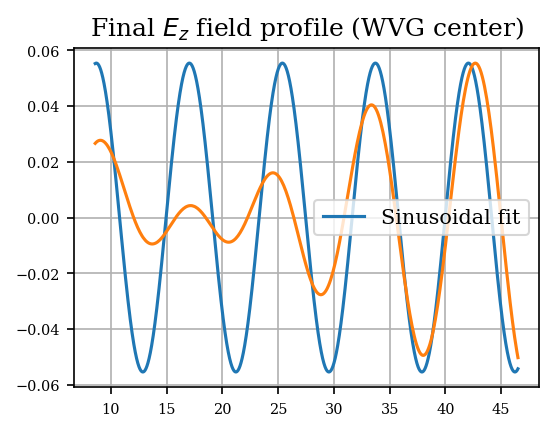

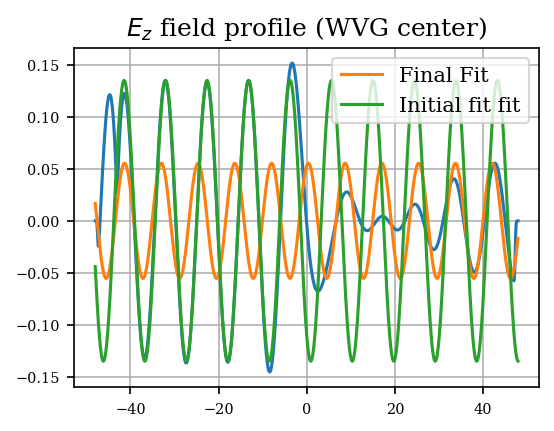

In [11]:
for index,d in enumerate(distances):
    print("###############")
    print("Beginning iteration: ",index)
    print("Distance: ", d)
    print("Frequency: ", loop_f_central_resonance[index])


    #Position properties
    wvg_x = 0
    wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

    ring_x = 0
    ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

    #Soure parameters
    source_x = x_bound_low + 4
    source_y = wvg_y

    source_width = wvg_width


    #Geometry objects
    waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                        center = mp.Vector3(wvg_x, wvg_y),
                        material = mp.Medium(index=n_wvg))
    ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                        center=mp.Vector3(ring_x, ring_y),
                        material = mp.Medium(index=n_ring))
    int_ring = mp.Cylinder(radius=ring_r,
                        center=mp.Vector3(ring_x, ring_y))

    geometry = [waveguide,
                ext_ring,
                int_ring]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.ContinuousSource(frequency=loop_f_central_resonance[index], width=50),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)


    #Simulate
    mp.verbosity(0)
    sim.run(until=run_time)

    ez_data_wvg = sim.get_array(center=mp.Vector3(0,wvg_y), size=mp.Vector3(sx, 0.001), component=mp.Ez)
    print(ez_data_wvg.shape)

    x = np.arange(-sx/2, sx/2, 1/resolution)

    init_mask = (x>(source_x + 0.4))&(x<((-1)*(ring_r+ring_w)))

    init_wave = ez_data_wvg[init_mask][:,0]
    init_x = x[init_mask]


    fin_mask = (x>(ring_r+ring_w))&(x<(x_bound_up-0.4))

    fin_wave = ez_data_wvg[fin_mask][:,0]
    fin_x = x[fin_mask]

    init_peaks, _ = find_peaks(init_wave)
    fin_peaks, _ = find_peaks(fin_wave)

    init_x_peaks = init_x[init_peaks]
    fin_x_peaks = fin_x[fin_peaks]

    def func_linear(m, k, phi):
        return (m*2*pi + pi/2 -phi)/k

    def func_1(x, k, phi):
        return np.amax(init_wave)*np.sin(k*x + phi)

    def func_2(x, k, phi):
        return np.amax(fin_wave)*np.sin(k*x + phi)

    popt_init, pcov_init = curve_fit(func_linear, [i[0] for i in enumerate(init_x_peaks)], init_x_peaks)

    k_fit_init = popt_init[0]
    phi_init = popt_init[1]%(2*pi)

    print("K_init: ",k_fit_init," phi_init:", phi_init)

    popt_fin, pcov_fin = curve_fit(func_linear, [i[0] for i in enumerate(fin_x_peaks)], fin_x_peaks)

    k_fit_fin = popt_fin[0]
    phi_fin = popt_fin[1]%(2*pi)

    print("K_fin: ",k_fit_fin," phi_fin:", phi_fin)


    Delta_Phi = (phi_fin - phi_init)%(2*pi)
    print("Delta Phi:", Delta_Phi, ", Degrees: ",Delta_Phi*360/(2*pi))

    Delta_Phi_list = np.append(Delta_Phi_list, Delta_Phi)
    sim.reset_meep()

    plt.figure()

    plt.plot(x, ez_data_wvg[:,0])

    plt.title(r"$E_z$ field profile (WVG center), d = " + d)
    plt.grid()

    plt.figure()

    dummy_x_init = np.arange(np.amin(init_x), np.amax(init_x), 0.01)

    plt.plot(dummy_x_init, func_1(dummy_x_init, *popt_init), label=r"Sinusoidal fit")
    plt.plot(init_x, init_wave)

    plt.title(r"Initial $E_z$ field profile (WVG center), d = " + d)
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x_fin = np.arange(np.amin(fin_x), np.amax(fin_x), 0.01)

    plt.plot(dummy_x_fin, func_2(dummy_x_fin, *popt_fin), label=r"Sinusoidal fit")
    plt.plot(fin_x, fin_wave)

    plt.title(r"Final $E_z$ field profile (WVG center), d = " + d)
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x = np.arange(np.amin(x), np.amax(x), 0.01)

    plt.plot(x, ez_data_wvg[:,0])
    plt.plot(dummy_x, func_2(dummy_x, *popt_fin), label=r"Final Fit")
    plt.plot(dummy_x, func_1(dummy_x, *popt_init), label=r"Initial fit fit")


    plt.title(r"$E_z$ field profile (WVG center), d = " + d)
    plt.legend()
    plt.grid()

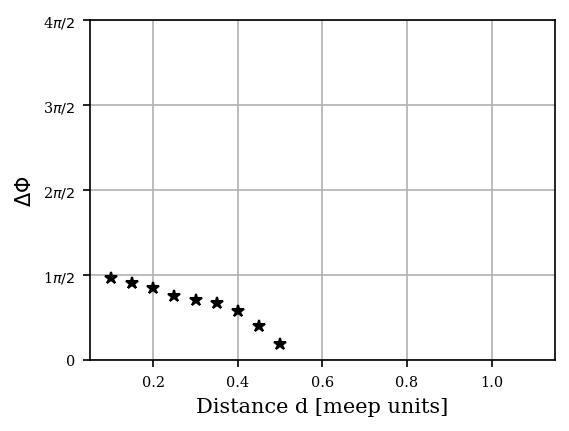

In [13]:


plt.plot(distances, Delta_Phi_list, "k*")

plt.xlabel(r"Distance d [meep units]")
plt.ylabel(r"$\Delta \Phi$")

ax = plt.gca()
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=np.pi/2))
ax.yaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi/2$'.format(val/(np.pi/2)) if val !=0 else '0'
))
plt.ylim(0,2*np.pi)

plt.grid()